# NCI WeatherBench-3c: Train a CNN - PyTorch

In this notebook we will go through all the steps required to train a fully convolutional neural network. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import seaborn as sns
import pickle
from score import *
from collections import OrderedDict
from dask.diagnostics import ProgressBar
from datetime import datetime
from dask.distributed import Client

In [2]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
client = Client(n_workers=12, threads_per_worker=1)  
client

[2024-04-14 16:50:01]


/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46349,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:33817,Total threads: 1
Dashboard: /proxy/35089/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:41461,


In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
res = '5.625'
print ('res:', res)
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print('DATADIR:', DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print('PREDDIR:', PREDDIR)
! mkdir -p {PREDDIR} 
! mkdir -p {PREDDIR+"/saved_models"} 

[2024-04-14 16:50:03]
res: 5.625
DATADIR: /g/data/wb00/NCI-Weatherbench/5.625deg
PREDDIR: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir


## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [5]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
valid_years = list(range( 2021, 2022+1))
print (valid_years)
z500_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*') ] 
t850_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')  ] 

z500_valid = load_test_data(z500_valid_files, 'z', slice('2021', '2022')).load()  
t850_valid = load_test_data(t850_valid_files, 't', slice('2021', '2022')).load() 
valid = xr.merge([z500_valid, t850_valid]).compute()

[2024-04-14 16:50:03]
[2021, 2022]
load_test_data, var: z
load_test_data, var: t
CPU times: user 12.5 s, sys: 1.95 s, total: 14.5 s
Wall time: 35.1 s


In [6]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
years = list(range(1999, 2022+1))
print (years)
z_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')  ] 
t_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    ] 

z = xr.open_mfdataset(z_files, combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=[500]).load()    
t = xr.open_mfdataset(t_files, combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=[850]).drop('level').load()  

[2024-04-14 16:50:38]
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
CPU times: user 1min 23s, sys: 8.87 s, total: 1min 32s
Wall time: 1min 47s


In [7]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
datasets = [z, t]
ds = xr.merge(datasets).compute()

[2024-04-14 16:52:26]
CPU times: user 2.85 ms, sys: 631 µs, total: 3.48 ms
Wall time: 2.68 ms


In [8]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
ds_train = ds.sel(time=slice( '1999', '2020' ))   
ds_test  = ds.sel(time=slice( '2021', '2022' ))  

[2024-04-14 16:52:26]
CPU times: user 10.7 ms, sys: 1.22 ms, total: 12 ms
Wall time: 10.5 ms


In [9]:
# PyTorch
from torch.utils.data import Dataset
class DataGenerator(Dataset):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
       
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            print (f"({var}, {levels})")
            try:
                data.append(ds[var].sel(level=levels))               
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))
            except KeyError:  
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        # Returns values 
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        X = np.einsum('klij->kjli', X)
        y = np.einsum('klij->kjli', y)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [10]:
dic = OrderedDict({'z': 500, 't': 500})

In [11]:
# Batch zise and lead time
bs=32
lead_time=6

In [12]:
ds_train

<xarray.Dataset>
Dimensions:  (level: 1, time: 192864, lat: 32, lon: 64)
Coordinates:
  * level    (level) int32 500
  * time     (time) datetime64[ns] 1999-01-01 ... 2020-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, level, lat, lon) float32 5.016e+04 5.017e+04 ... 5.151e+04
    t        (time, level, lat, lon) float32 254.1 254.5 254.7 ... 261.8 261.4

In [13]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
print ('Start year: 1999')
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1999', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2020')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

[2024-04-14 16:52:26]
Start year: 1999
(z, 500)
(t, 500)
Loading data into RAM
(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 17.3 s, sys: 2.9 s, total: 20.2 s
Wall time: 16.9 s


In [14]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54140.027  ,   274.65103], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500,
 <xarray.DataArray 'z' (level: 2)>
 array([1100.1848  ,    5.642098], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500)

In [15]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

[2024-04-14 16:52:43]
(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 154 ms, sys: 157 ms, total: 311 ms
Wall time: 266 ms


## Create and train model

Next up, we need to create the model architecture. Here we will use a fully connected convolutional network. Because the Earth is periodic in longitude, we want to use a periodic convolution in the lon-direction. This is not implemented in Keras, so we have to do it manually.

In [16]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class PeriodicPadding2D(nn.Module):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def forward(self, inputs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = torch.cat( 
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        inputs_padded =  F.pad (inputs_padded, (self.pad_width, self.pad_width) )
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size):
        super().__init__()        
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = nn.Conv2d(     
            in_channel, out_channel, kernel_size)  

    def forward(self, inputs):
        return self.conv(self.padding(inputs))
        #return self.conv(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [17]:
# Pytorch
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  PeriodicConv2D(2, 64, 5)
        self.activ1 = nn.LeakyReLU()
        
        self.conv2 =  PeriodicConv2D(64, 64, 5)
        self.activ2 = nn.LeakyReLU()
        
        self.conv3 =  PeriodicConv2D(64, 64, 5)
        self.activ3 = nn.LeakyReLU()
        
        self.conv4 =  PeriodicConv2D(64, 64, 5)
        self.activ4 = nn.LeakyReLU()
        
        self.conv5 =  PeriodicConv2D(64, 64, 5)
        self.activ5 = nn.LeakyReLU()
        
        self.conv6 =  PeriodicConv2D(64, 2, 5)

    def forward (self, x):
        x = self.conv1(self.activ1(x))
        x = self.conv2(self.activ2(x))
        x = self.conv3(self.activ3(x))
        x = self.conv4(self.activ4(x))
        x = self.conv5(self.activ5(x))
        x = self.conv6(x)  
        return x

cnn = Model()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)


In [18]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 6}
dg_train_generator = torch.utils.data.DataLoader(dg_train, **params)
params['shuffle'] = False
dg_valid_generator = torch.utils.data.DataLoader(dg_valid, **params)
dg_test_generator = torch.utils.data.DataLoader(dg_test, **params)

In [19]:
print('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn.to(device)
print ("torch - num threads:", torch.get_num_threads() ) 

cuda
torch - num threads: 1


In [20]:
%%time
n_epochs = 100   
#batch_size = 32
patience = 5
best_loss = float('inf')
 
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []     
    
for epoch in range(n_epochs):
    for X, y in dg_train_generator:
        cnn.train()
        X  = torch.squeeze( X )
        X = X.to(device)
        y_pred = cnn(X)
        y  = torch.squeeze( y )
        y = y.to(device)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
      
    cnn.eval()
    with torch.no_grad():
        for X_v, y_v in dg_valid_generator:
            X_v  = torch.squeeze( X_v )
            y_v  = torch.squeeze( y_v )
            X_v = X_v.to(device)
            y_v = y_v.to(device)

            y_v_pred = cnn(X_v)
            loss_v = loss_fn(y_v_pred, y_v)
            valid_losses.append(loss_v.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    train_losses = []
    valid_losses = []  

    if loss_v < best_loss:  
        best_loss = loss_v
        patience = 5   
    else:
        patience -= 1
        if patience == 0:
            print(f'Early stopping')
            break               

[  0/100] train_loss: 0.20034 valid_loss: 0.07879
[  1/100] train_loss: 0.06531 valid_loss: 0.05853
[  2/100] train_loss: 0.05337 valid_loss: 0.05303
[  3/100] train_loss: 0.04808 valid_loss: 0.04663
[  4/100] train_loss: 0.04473 valid_loss: 0.04405
[  5/100] train_loss: 0.04237 valid_loss: 0.04275
[  6/100] train_loss: 0.04061 valid_loss: 0.04041
[  7/100] train_loss: 0.03920 valid_loss: 0.03944
[  8/100] train_loss: 0.03805 valid_loss: 0.03817
[  9/100] train_loss: 0.03708 valid_loss: 0.03703
[ 10/100] train_loss: 0.03622 valid_loss: 0.03620
[ 11/100] train_loss: 0.03547 valid_loss: 0.03763
[ 12/100] train_loss: 0.03479 valid_loss: 0.03583
[ 13/100] train_loss: 0.03419 valid_loss: 0.03428
[ 14/100] train_loss: 0.03363 valid_loss: 0.03457
[ 15/100] train_loss: 0.03315 valid_loss: 0.03369
[ 16/100] train_loss: 0.03271 valid_loss: 0.03346
[ 17/100] train_loss: 0.03229 valid_loss: 0.03300
[ 18/100] train_loss: 0.03195 valid_loss: 0.03260
[ 19/100] train_loss: 0.03162 valid_loss: 0.03228


## Create predictions

Now that we have our model we need to create a prediction NetCDF file. This function does this. 

We can either directly predict the target lead time (e.g. 5 days) or create an iterative forecast by chaining together many e.g. 6h forecasts.

In [21]:
# PyTorch
def create_predictions(model, dg, mean, std, var_dict, valid_time, lat, lon):
    """Create predictions for non-iterative model"""

    test_losses = [] 
    fcs = []
    preds_list = []
    
    model.to (device)
    mean = torch.from_numpy(mean).to (device)
    std  = torch.from_numpy(std).to (device)
    model.eval()
    with torch.no_grad():
        for X_t, y_t in dg:
            X_t  = torch.squeeze( X_t )
            y_t  = torch.squeeze( y_t )
            X_t = X_t.to(device)
            y_t = y_t.to(device)

            y_t_pred = model(X_t)
            preds_list.append( y_t_pred * std[:,None, None] + mean[:,None, None] )
    
    preds = torch.cat (preds_list, dim=0)
    print (preds.shape)
    
    fcs = []
    lev_idx = 0
    
    for var, levels in var_dict.items(): 
        if levels is None or isinstance(levels, int):
            fcs.append(xr.DataArray(
                preds[ : , lev_idx, : , : ].cpu(),
                dims=['time', 'lat', 'lon'],
                coords={'time': valid_time, 'lat': lat, 'lon': lon } ,
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[ : , lev_idx::lev_idx+nlevs, : , : ].cpu(),
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': valid_time, 'lat': lat, 'lon': lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
            
    return xr.merge(fcs)    

In [22]:
%%time
# Pytroch
print( f'[{datetime.now().replace(microsecond=0)}]' )

fc = create_predictions(cnn, dg_test_generator, 
                        mean=dg_train.mean.values, std=dg_train.std.values,
                        var_dict=dg_test.var_dict,
                        valid_time=dg_test.valid_time, 
                        lat=dg_test.ds.lat, 
                        lon=dg_test.ds.lon 
                       )

[2024-04-14 18:30:24]
torch.Size([17514, 2, 32, 64])
CPU times: user 4.61 s, sys: 1.06 s, total: 5.66 s
Wall time: 8.44 s


In [23]:
print( valid['time'])
print(    fc['time'])

<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T06:00:00.000000000', '2021-01-01T07:00:00.000000000',
       '2021-01-01T08:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T06:00:00 ... 2022-12-31T23:00:00


In [24]:
fc

<xarray.Dataset>
Dimensions:  (time: 17514, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T06:00:00 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 4.869e+04 4.864e+04 ... 5.07e+04 5.068e+04
    t        (time, lat, lon) float32 253.6 253.2 253.0 ... 259.0 259.6 259.6

In [25]:
%%time
rmse_1 = compute_weighted_rmse(fc, valid).compute()
print (rmse_1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 109.8
    t        float64 1.109
CPU times: user 605 ms, sys: 428 ms, total: 1.03 s
Wall time: 846 ms


### Iterative predictions

In [26]:
#PyTorch
def create_iterative_predictions(model, dg_test_generator,
                                max_lead_time,
                                mean, std, var_dict, valid_time, lat, lon,
                                state, lead_time, init_time):
    
    mean = torch.from_numpy(mean).to (device)
    std  = torch.from_numpy(std).to (device)

    state = torch.from_numpy(state.values)  
    state = torch.einsum('klij->kjli', state)
    print (state.shape)
    
    params = {'batch_size': 32,
          'shuffle': False,
          'num_workers': 6}
    
    preds = []
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_lead_time // lead_time):

            state_generator = torch.utils.data.DataLoader(state, **params)
            ys = []
            preds_list = []
            
            for X in state_generator:
                X = X.to(device)
                y_t_pred = model(X)
                ys.append(y_t_pred)
                preds_list.append( y_t_pred * std[:,None, None] + mean[:,None, None] )
                
            del state
            del state_generator
            
            state = torch.cat(ys)
            state = state.cpu()
            preds.append( torch.cat(preds_list).cpu() )
            
            print (f'Finish - loop {i}')
            
        preds =  np.stack(preds)  
    print (preds.shape)
    
    lead_time = np.arange(lead_time, max_lead_time + lead_time, lead_time)
    fcs = []
    lev_idx = 0
    
    for var, levels in var_dict.items():  
        if levels is None or isinstance(levels, int):
            fcs.append(xr.DataArray(
                preds[ : , : , lev_idx, : , : ],  
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': init_time, 'lat': lat, 'lon': lon},
                name=var
            ))
            lev_idx += 1
            
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[ : , : , lev_idx:lev_idx+nlevs, : , : ],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': init_time, 'lat': lat, 'lon': lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
                       
    return xr.merge(fcs)      

In [27]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
fc_iter = create_iterative_predictions( cnn, dg_test_generator, 
                                        max_lead_time= 5*24,
                                        mean=dg_train.mean.values, std=dg_train.std.values,
                                        var_dict=dg_test.var_dict,
                                        valid_time=dg_test.valid_time, 
                                        lat=dg_test.ds.lat, 
                                        lon=dg_test.ds.lon,
                                        state=dg_test.data[:dg_test.n_samples], 
                                        lead_time=dg_test.lead_time, 
                                        init_time=dg_test.init_time
                                        )

[2024-04-14 18:30:34]
torch.Size([17514, 2, 32, 64])
Finish - loop 0
Finish - loop 1
Finish - loop 2
Finish - loop 3
Finish - loop 4
Finish - loop 5
Finish - loop 6
Finish - loop 7
Finish - loop 8
Finish - loop 9
Finish - loop 10
Finish - loop 11
Finish - loop 12
Finish - loop 13
Finish - loop 14
Finish - loop 15
Finish - loop 16
Finish - loop 17
Finish - loop 18
Finish - loop 19
(20, 17514, 2, 32, 64)
CPU times: user 1min 35s, sys: 25.6 s, total: 2min 1s
Wall time: 2min 56s


In [28]:
print (fc_iter['time'])
print (  valid['time'])

<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T15:00:00.000000000',
       '2022-12-31T16:00:00.000000000', '2022-12-31T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00


In [29]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t = evaluate_iterative_forecast(fc_iter, valid, compute_weighted_rmse)

[2024-04-14 18:33:30]
Merging ...
CPU times: user 13.1 s, sys: 9.37 s, total: 22.4 s
Wall time: 18.5 s


[2024-04-14 18:33:49]


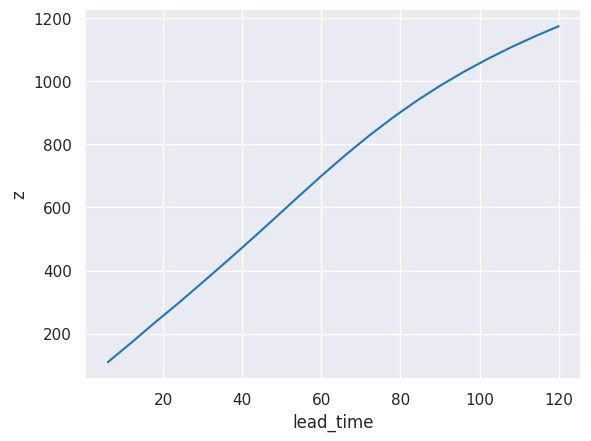

In [30]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t.z.plot()

[2024-04-14 18:33:49]


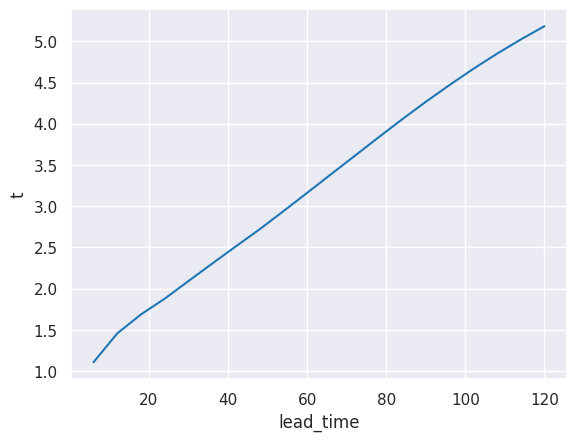

In [31]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t.t.plot()

# The end